# Hierarchical Gaussian Filter

In [ ]:
# Activate local environment, see `Project.toml`
import Pkg; Pkg.activate(".."); Pkg.instantiate(); 

In this demo the goal is to perform approximate variational Bayesian Inference for Univariate Hierarchical Gaussian Filter (HGF).

Simple HGF model can be defined as:

$$\begin{aligned}
  x^{(j)}_k & \sim \, \mathcal{N}(x^{(j)}_{k - 1}, f_k(x^{(j - 1)}_k)) \\
  y_k & \sim \, \mathcal{N}(x^{(j)}_k, \tau_k)
\end{aligned}$$

where $j$ is an index of layer in hierarchy, $k$ is a time step and $f_k$ is a variance activation function. `RxInfer.jl` export Gaussian Controlled Variance (GCV) node with $f_k = \exp(\kappa x + \omega)$ variance activation function. By default the node uses Gauss-Hermite cubature with a prespecified number of approximation points in the cubature. In this demo we also show how we can change the hyperparameters in different approximation methods (iin this case Gauss-Hermite cubature) with the help of metadata structures. Here how our model will look like with the GCV node:

$$\begin{aligned}
  z_k & \sim \, \mathcal{N}(z_{k - 1}, \mathcal{\tau_z}) \\
  x_k & \sim \, \mathcal{N}(x_{k - 1}, \exp(\kappa z_k + \omega)) \\
  y_k & \sim \, \mathcal{N}(x_k, \mathcal{\tau_y})
\end{aligned}$$

In this experiment we will create a single time step of the graph and perform variational message passing filtering alrogithm to estimate hidden states of the system. For a more rigorous introduction to Hierarchical Gaussian Filter we refer to [Ismail Senoz, Online Message Passing-based Inference in the Hierarchical Gaussian Filter](https://ieeexplore.ieee.org/document/9173980) paper.

For simplicity we will consider $\tau_z$, $\tau_y$, $\kappa$ and $\omega$ known and fixed, but there are no principled limitations to make them random variables too.

To model this process in `RxInfer`, first, we start with importing all needed packages:

In [3]:
using RxInfer, BenchmarkTools, Random, Plots

Next step, is to generate some synthetic data:

In [4]:
function generate_data(rng, k, w, zv, yv)
    z_prev = 0.0
    x_prev = 0.0

    z = Vector{Float64}(undef, n)
    v = Vector{Float64}(undef, n)
    x = Vector{Float64}(undef, n)
    y = Vector{Float64}(undef, n)

    for i in 1:n
        z[i] = rand(rng, Normal(z_prev, sqrt(zv)))
        v[i] = exp(k * z[i] + w)
        x[i] = rand(rng, Normal(x_prev, sqrt(v[i])))
        y[i] = rand(rng, Normal(x[i], sqrt(yv)))

        z_prev = z[i]
        x_prev = x[i]
    end 
    
    return z, x, y
end

generate_data (generic function with 1 method)

In [5]:
# Seed for reproducibility
seed = 42

rng = MersenneTwister(seed)

# Parameters of HGF process
real_k = 1.0
real_w = 0.0
z_variance = abs2(0.2)
y_variance = abs2(0.1)

# Number of observations
n = 300

z, x, y = generate_data(rng, real_k, real_w, z_variance, y_variance);

Let's plot our synthetic dataset. Lines represent our hidden states we want to estimate using noisy observations.

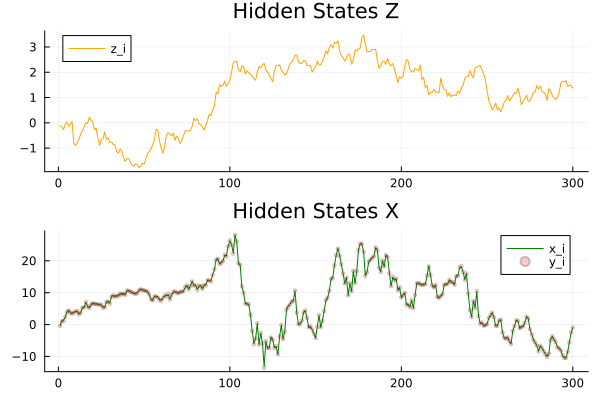

In [6]:
let 
    pz = plot(title = "Hidden States Z")
    px = plot(title = "Hidden States X")
    
    plot!(pz, 1:n, z, label = "z_i", color = :orange)
    plot!(px, 1:n, x, label = "x_i", color = :green)
    scatter!(px, 1:n, y, label = "y_i", color = :red, ms = 2, alpha = 0.2)
    
    plot(pz, px, layout = @layout([ a; b ]))
end

To create a model we use the `@model` macro:

In [7]:
# We create a single-time step of corresponding state-space process to
# perform online learning (filtering)
@model function hgf(real_k, real_w, z_variance, y_variance)
    
    # Priors from previous time step for `z`
    zt_min_mean = datavar(Float64)
    zt_min_var  = datavar(Float64)
    
    # Priors from previous time step for `x`
    xt_min_mean = datavar(Float64)
    xt_min_var  = datavar(Float64)

    zt_min ~ NormalMeanVariance(zt_min_mean, zt_min_var)
    xt_min ~ NormalMeanVariance(xt_min_mean, xt_min_var)

    # Higher layer is modelled as a random walk 
    zt ~ NormalMeanVariance(zt_min, z_variance)
    
    # Lower layer is modelled with `GCV` node
    gcvnode, xt ~ GCV(xt_min, zt, real_k, real_w)
    
    # Noisy observations 
    y = datavar(Float64)
    y ~ NormalMeanVariance(xt, y_variance)
    
    return gcvnode
end

@constraints function hgfconstraints() 
    q(xt, zt, xt_min) = q(xt, xt_min)q(zt)
end

@meta function hgfmeta()
    # Lets use 31 approximation points in the Gauss Hermite cubature approximation method
    GCV(xt_min, xt, zt) -> GCVMetadata(GaussHermiteCubature(31)) 
end

hgfmeta (generic function with 1 method)

In [8]:
function run_inference(data, real_k, real_w, z_variance, y_variance)

    autoupdates   = @autoupdates begin
        zt_min_mean, zt_min_var = mean_var(q(zt))
        xt_min_mean, xt_min_var = mean_var(q(xt))
    end

    return infer(
        model         = hgf(real_k, real_w, z_variance, y_variance),
        constraints   = hgfconstraints(),
        meta          = hgfmeta(),
        data          = (y = data, ),
        autoupdates   = autoupdates,
        keephistory   = length(data),
        historyvars    = (
            xt = KeepLast(),
            zt = KeepLast()
        ),
        initmarginals = (
            zt = NormalMeanVariance(0.0, 5.0),
            xt = NormalMeanVariance(0.0, 5.0),
        ), 
        iterations    = 5,
        free_energy   = true,
        autostart     = true,
        callbacks     = (
            after_model_creation = (model, returnval) -> begin 
                gcvnode = returnval
                setmarginal!(gcvnode, :y_x, MvNormalMeanCovariance([ 0.0, 0.0 ], [ 5.0, 5.0 ]))
            end,
        )
    )
end

run_inference (generic function with 1 method)

In [9]:
result = run_inference(y, real_k, real_w, z_variance, y_variance);

mz = result.history[:zt];
mx = result.history[:xt];

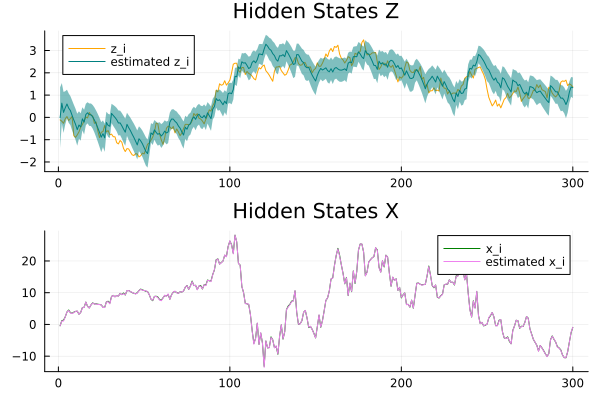

In [10]:
let 
    pz = plot(title = "Hidden States Z")
    px = plot(title = "Hidden States X")
    
    plot!(pz, 1:n, z, label = "z_i", color = :orange)
    plot!(pz, 1:n, mean.(mz), ribbon = std.(mz), label = "estimated z_i", color = :teal)
    
    plot!(px, 1:n, x, label = "x_i", color = :green)
    plot!(px, 1:n, mean.(mx), ribbon = std.(mx), label = "estimated x_i", color = :violet)
    
    plot(pz, px, layout = @layout([ a; b ]))
end

As we can see from our plot, estimated signal resembles closely to the real hidden states with small variance. We maybe also interested in the values for Bethe Free Energy functional:

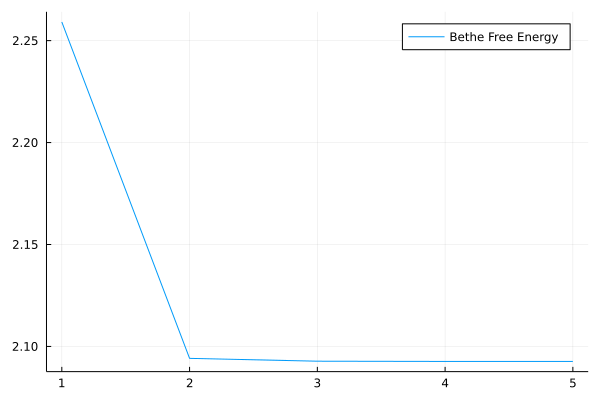

In [10]:
plot(result.free_energy_history, label = "Bethe Free Energy")

As we can see BetheFreeEnergy converges nicely to a stable point.

At final, lets check the overall performance of our resulting Variational Message Passing algorithm:

In [11]:
@benchmark run_inference($y, $real_k, $real_w, $z_variance, $y_variance)

BenchmarkTools.Trial: 59 samples with 1 evaluation.
 Range (min … max):  79.991 ms … 100.186 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     83.369 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   85.951 ms ±   6.225 ms  ┊ GC (mean ± σ):  2.23% ± 4.14%

           █▄▁                                                  
  ▃▅▃▅▅▃█▆▆███▅▃▃▃▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▅▆▁▃▃▁▃▃▃ ▁
  80 ms           Histogram: frequency by time         99.6 ms <

 Memory estimate: 20.09 MiB, allocs estimate: 416348.